In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/functions/')
from Amplitude import Amplitude
from fio import readin

# Helper function 1 that read in one set of parameter with the time given in postfix_index_set
def iter_onecase(postfix_index_set, tag_set, tag_common):
    '''
    postfix_index_set: list of numbers
        A list of corresponding indices used to distinguish the cases.
    tag_set: list of strings
        A list of tags that distinguish each case, can be different from the index set 
    
    '''

    # Instantiate amplitude as a list
    amplitude = []
    
    for i,(index,tag) in enumerate(zip(postfix_index_set, tag_set)):   
        # Use the enhanced read-in function   
        # Rewrite the line according to the file naming 
        # filename = 'filename_common' + '%g' %postfix_index + file_format
        filename = './diagnostics/eta' + '%g.dat' %tag
        # Rewrite this line according to the delimiter and the fields attributes
        eta, exists = readin(filename, table_headers = ['x','eta','f','p','p_p1','p_p2','p_m1','p_m2','tau_x','tau_y','u_x','u_y','n_x','n_y'], 
                             table_delimiter = ',')
        if exists:
            # eta.rename(columns={'pos':'eta'}, inplace=True)
            # Instantiate a amplitude class member
            ampl = Amplitude(eta[['x', 'eta', 'f']])
            amplitude.append(ampl)
    return amplitude, exists

# Helper function 2 that iterates through different parameter set 
def iter_para_newversion(para_pair_set, para_name, common_path, postfix_index, tag):
    amplitude_set = []
    energydirect_set = []
    for p in tqdm(para_pair_set):
        # Assemble the directory name corresponding to each parameter set
        # Example: dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
        dirname = 'linlog_m5B0'
        for i,name in enumerate(para_name):
            if name == 'Re':
                dirname += name + '%g' %p[i] + '.'
            else:
                dirname += name + '%g' %p[i]  
        # Change path 
        os.chdir(common_path + dirname)
        # Call iter_onecase, pass directory name as a parameter
        amplitude, exists = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')
        # If the file does not exceed, do not append
        if exists:
            amplitude_set.append(amplitude)
        energy, exists = readin('budgetWaterwind.dat', table_delimiter = ' ', skipn = 100)
        if exists:
            # HERE IS THE DIFFERENCE! 
            # total = energy.ke/2 + energy.gpe
            total = energy.ke + energy.gpe
            diss = np.zeros(energy.shape[0])
            for i, row in energy.iterrows():
                if i == 0:
                    diss[i] = 0
                    last_t = row['t'] # record t in last row
                else:
                    diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
                    last_t = row['t']
            energy.insert(len(energy.columns), "total", total, True)
            energy.insert(len(energy.columns), "total_diss", total+diss, True)
            energydirect_set.append(energy)       
    return amplitude_set, energydirect_set

# Set the style
from matplotlib import rc
# text and font
## small, medium, large, x-large, xx-large, larger, or smaller
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'large'
# Figure size
plt.rcParams['figure.figsize'] = 8, 4.8 ## figure size in inches
plt.rcParams['figure.dpi'] = 1200        ## figure dots per inchfigsize : 6.4, 4.8
# Line
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10
# Ticks
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.size'] = 3.5

6.774383342429144e-05
0.016850026


AttributeError: 'DataFrame' object has no attribute 'tau'

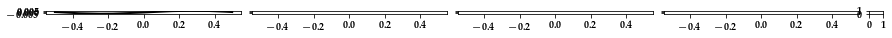

In [3]:
# Plot the pressure and shear distribution along the wave
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(15,5))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# mu_air = 1/RE*(17.4e-6/8.9e-4)
# tau = rho*u*^2 = 1/850*0.44*sqrt(g_/k_+f.sigma*k_)
Ustar = 0.6; Bo = 200; k = 2*np.pi; sigma = 1./(Bo*k**2); g = 1
# Ustar = 0.616; Bo = 1.47; k = 2*np.pi; sigma = 1./(Bo*k**2); g = 1
tau = 1/850*(Ustar*(g/k+sigma*k)**0.5)**2
print(tau)

for i,ax in zip(range(9,13),grid):
    common_path = '/home/jiarong/research/projects/windwave/miscellaneous/linlog_adaptive_limited_m5B0Ustar0.6ak0.05Bo200Re100000.LEVEL11'
#    common_path = '/home/jiarong/research/projects/windwave/linear_limited_secondrun_m5B0Ustar0.616ak0.05Bo1.47Re31000.LEVEL11'
#    common_path = '/home/jiarong/research/projects/windwave/miscellaneous/linear_adaptive_varyslope_limited_m5B0Ustar0.44ak0.05Bo3.34Re31000.LEVEL10'
    # file = '/home/jiarong/research/projects/windwave/miscellaneous/linlog_m5B0Ustar0.44ak0.05Bo200Re100000.LEVEL11_secondrun/pressure//p_air_matrix%g.dat' % (i/32)
    # file = '/home/jiarong/research/projects/windwave/miscellaneous/linear_adaptive_varyslope_limited_m5B0Ustar0.44ak0.05Bo3.34Re31000.LEVEL10/pressure/p_air_matrix%g.dat' %(i/32)
    pfile = common_path + '/matrix/p%g.dat' %(i/32)
    ffile = common_path + '/matrix/f%g.dat' %(i/32)
    pressure = np.fromfile(pfile, dtype=np.float32)
    f = np.fromfile(ffile, dtype=np.float32)
    f = f.reshape((513,513))
    f = f[1:,1:]
    pressure = pressure.reshape((513,513))
    pressure = pressure[1:,1:]
    p_air = pressure
    p_air_part = p_air[abs(p_air) > 0]
    aver = p_air_part.mean()
    print(aver)
    p_air_norm = (p_air-aver)/tau*(1-f)
    # Plot the interface
    etafile = common_path + '/field/eta%g' %(i/32)
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f']])    
    image = np.rot90(p_air_norm)
#     pcontour = ax.imshow(image, extent=(0,1,0,1), cmap='RdBu', vmin=-10, vmax=10)
    ax.plot(ampl._eta_data.x, ampl._eta_data.eta, color='k', linewidth=2)
    ax.plot(ampl._eta_data.x, ampl._eta_data.tau)
    ax.plot(ampl._eta_data.x, ampl._eta_data.p)
    ax.set_axis_off()
    ax.set_title('t=%gT' %(i/32))


In [4]:
print(ampl._eta_data)

             x       eta         f
1015 -0.499756  0.001108  0.269440
1016 -0.499268  0.001076  0.202905
1017 -0.498779  0.001044  0.137647
1018 -0.498291  0.001012  0.073531
1021 -0.497803  0.000981  0.013654
1019 -0.497803  0.000981  0.996302
1020 -0.497314  0.000951  0.947319
1022 -0.496826  0.000921  0.886190
1023 -0.496338  0.000892  0.826246
1024 -0.495850  0.000863  0.767383
1025 -0.495361  0.000835  0.709462
1026 -0.494873  0.000807  0.652322
1027 -0.494385  0.000779  0.595811
1028 -0.493896  0.000752  0.539787
1029 -0.493408  0.000725  0.484108
1030 -0.492920  0.000698  0.428690
1031 -0.492432  0.000671  0.373505
1032 -0.491943  0.000644  0.318531
1033 -0.491455  0.000617  0.263725
1034 -0.490967  0.000590  0.208922
1035 -0.490479  0.000563  0.153947
1036 -0.489990  0.000536  0.098655
1037 -0.489502  0.000509  0.043108
1038 -0.489014  0.000482  0.984464
1039 -0.489014  0.000482  0.001912
1040 -0.488525  0.000454  0.929684
1041 -0.488037  0.000426  0.872904
1042 -0.487549  0.00